<a href="https://colab.research.google.com/github/Jayveersinh-Raj/Nature_Inspired_Computing_Labs/blob/main/GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[//]: # (Based on https://github.com/trevorstephens/gplearn/blob/main/doc/gp_examples.ipynb)
# Genetic Programming
> Genetic algorithms are powerful optimization techniques, but they have
> an inherent limitation: they incorporate the assumed solution structure in
> the representation of their candidate solutions.
> For instance, if we want to use a GA to solve a problem with 10 variables,
> then the GA chromosome is typically represented as $(x_1, x_2, · · ·, x_{10})$·
> This can be a disadvantage for GAs when we don't not know which parameters
> need to be optimized in a given problem. Also, we may not know the structure
> of the parameters that need to be optimized. Are the parameters real numbers,
> or state space machines, or computer programs, or complex arrays, or time
> schedules, or something else?"
>
> -- Evolutionary Optimization Algorithms(book)

GP is an EA approach that trys not only to learn the best parameter to a fixed
structure, but to lean the best structure to represent the problem.

![Genetic programming tree](https://upload.wikimedia.org/wikipedia/commons/f/f9/Genetic_programming_mutation.gif?20210608182634)


In [2]:
!pip install gplearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%matplotlib inline
from gplearn.genetic import SymbolicRegressor, SymbolicClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import graphviz

Let's consider the following problem:

$ F(X_0,X_1) = X_0^2 -X_1^2 + X_0 - 1$

Remember from IML that if we use linear regression, we can't fit this function
properly, because LR assumes a linear relation, and to solve that we had to
generate polynomial features ourselves.

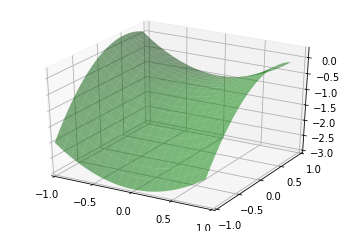

In [4]:
# Ground truth
x0 = np.arange(-1, 1, .1)
x1 = np.arange(-1, 1, .1)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.arange(-1, 1.01, .5))
ax.set_yticks(np.arange(-1, 1.01, .5))
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, color='green', alpha=0.5)
plt.show()

Try both with and without noise

In [5]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1
y_train = y_train +  + np.random.randn(*y_train.shape) * 0.05 # added noise

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

In [6]:
# https://gplearn.readthedocs.io/en/stable/reference.html#symbolic-regressor
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.574        5         0.325618          0.56347      2.03m
   1     9.94           1.6638        5         0.321408         0.656388      1.38m
   2     7.69          1.92859       11         0.237281         0.525339      1.38m
   3     5.34         0.988323        7         0.235707         0.717672      1.17m
   4     4.68         0.885783       11        0.0979963        0.0993065      1.13m
   5     5.70         0.948446       11        0.0585932        0.0751571      1.11m
   6     7.08          1.09749       11        0.0393246         0.036184     56.93s
   7     7.50          1.81561       11        0.0382028        0.0462802      1.09m
   8     8.02          1.07971       11        0.0487342        0.0486221  

SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [7]:
print(est_gp._program)


add(mul(X0, X0), sub(add(-0.956, X1), mul(mul(div(-0.597, -0.330), mul(X1, 0.583)), X1)))


In [8]:
# DT
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)
# RF
est_rf = RandomForestRegressor(n_estimators=10)
est_rf.fit(X_train, y_train)
# lr
est_lr = LinearRegression()
est_lr.fit(X_train, y_train)
# PR
poly = PolynomialFeatures(2)
est_pr = LinearRegression()
est_pr.fit(poly.fit_transform(X_train), y_train)


LinearRegression()

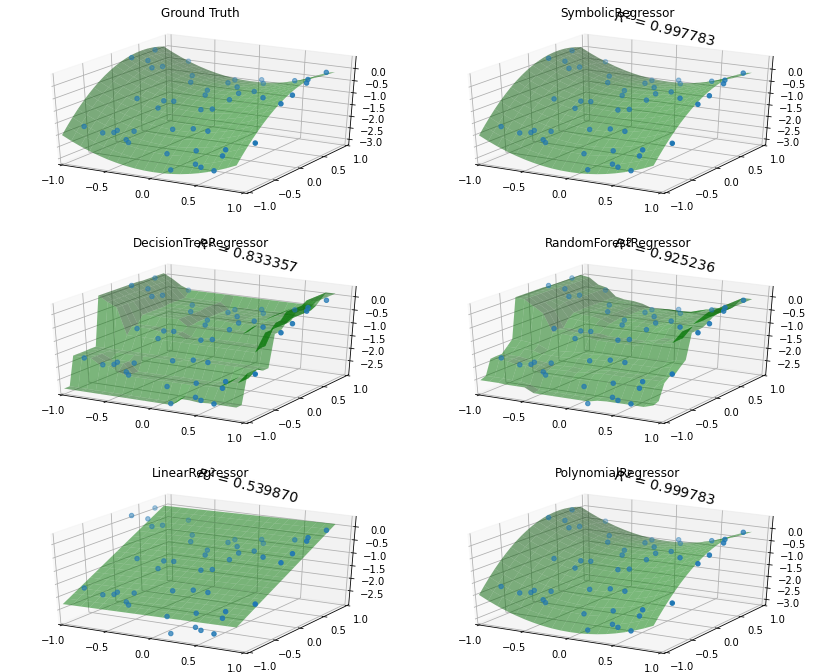

In [9]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)

y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)

y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

y_lr = est_lr.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_lr = est_lr.score(X_test, y_test)

y_pr = est_pr.predict(poly.transform(np.c_[x0.ravel(), x1.ravel()])).reshape(x0.shape)
score_pr = est_pr.score(poly.transform(X_test), y_test)

models_stats = [
    (y_truth, None, "Ground Truth"),
    (y_gp, score_gp, "SymbolicRegressor"),
    (y_tree, score_tree, "DecisionTreeRegressor"),
    (y_rf, score_rf, "RandomForestRegressor"),
    (y_lr, score_lr, "LinearRegressor"),
    (y_pr, score_pr, "PolynomialRegressor"),
]


fig = plt.figure(figsize=(12, 10))
for i, (y, score, title) in enumerate(models_stats):

    ax = fig.add_subplot(3, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(-1, 1.01, .5))
    ax.set_yticks(np.arange(-1, 1.01, .5))
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title, pad=20)

# using padding
fig.tight_layout(pad=3.0)
plt.show()

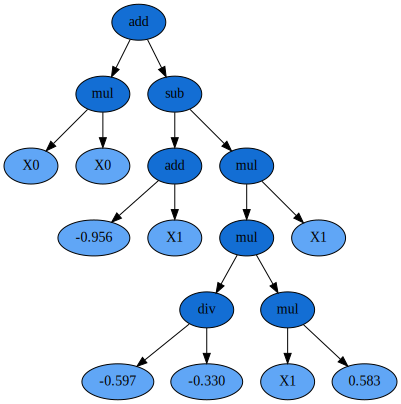

In [10]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

gplearn also have a classifier and a transformer

We can limit the allowed functions that GP uses, or exted them with our own

ROC AUC score: 0.9736686390532545
Acc: 0.9053254437869822


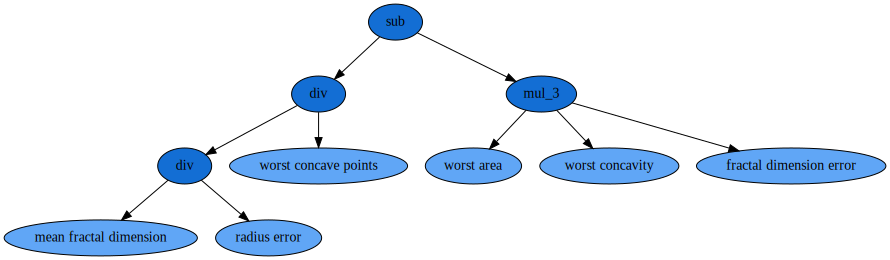

In [11]:
from gplearn.functions import make_function
def mul_3(x1, x2, x3):
    return x1*x2*x3

mul_3 = make_function(function=mul_3,
                        name='mul_3',
                        arity=3)

function_set = ['add', 'sub', 'div', mul_3]  # Instead of 'mul'

rng = check_random_state(0)
cancer = load_breast_cancer()
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         function_set=function_set,
                         random_state=1)
est.fit(cancer.data[:400], cancer.target[:400])

y_true = cancer.target[400:]
y_score = est.predict_proba(cancer.data[400:])[:,1]
print('ROC AUC score:', roc_auc_score(y_true, y_score))  # https://www.youtube.com/watch?v=4jRBRDbJemM

print('Acc:', est.score(cancer.data[400:], cancer.target[400:]))

dot_data = est._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

### What about categorical data?
We can use ordinal or one hot encoders to encode our categories to numbers.
But, DTs and RF can handle categorical data by making different branch for
each category.

This paper discusses how can we extend GP to support categorical data
> A multi-way branch node which.
>
> A series of ‘if-then-else’.
>
> -- [Genetic Programming for Classification: An Analysis of Convergence Behaviour](https://link.springer.com/chapter/10.1007/3-540-36187-1_27)

# TPOT
![TPOR](https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-logo.jpg)

Stands for "Tree-based Pipeline Optimization Tool", it's a library that uses GP to
get the best pipeline from sklearn/torch


In [ ]:
from tpot import TPOTClassifier

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    train_size=0.75, test_size=0.25, random_state=42)

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

D:\University\TA\F22 NIC\venv\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9844058928817294

Generation 2 - Current best internal CV score: 0.9844058928817294

Generation 3 - Current best internal CV score: 0.9844058928817294

Generation 4 - Current best internal CV score: 0.9866363761531047

Generation 5 - Current best internal CV score: 0.9866363761531047

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=2, p=2, weights=distance)
0.9822222222222222


D:\University\TA\F22 NIC\venv\lib\site-packages\sklearn\metrics\_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


In [ ]:
# We can get the code that generates the best model
tpot.export('tpot_digits_pipeline.py')

TPOT can even accept custom classes, you can explore this [link](http://epistasislab.github.io/tpot/)